# Exploring DAQ parameters with SACLA June 2014 data

## Loading and definitions

In [2]:
import h5py
import numpy as np
import matplotlib
# matplotlib.rcParams = matplotlib.rc_params_from_file("/swissfel/photonics/sala/sacla/utilities/matplotlibrc")
# Use this if you want to change the default figure size
#matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['image.origin'] = "nearer"
matplotlib.use("nbagg")

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
import os
from time import time

from numba import autojit
# Where libs for analyzing SACLA code are:
#SACLA_UTILS = "/swissfel/photonics/software/python-code/sacla/"
SACLA_UTILS = "/swissfel/photonics/sala/sacla"
sys.path.append(SACLA_UTILS)
import utilities as ut
reload(ut)
reload(ut.analysis)

# how fast is trivial parallelization? 
from IPython.parallel import Client

# Create a client, and a load_balanced_view object
rc = Client()
lview = rc.load_balanced_view()
lview.block = True
    
DIR = "/swissfel/photonics/data/2014-06-11_SACLA_ES2/hdf5_wdaq_mpccdonly/"

ModuleNotFoundError: No module named 'utilities'

## Exploration

Let's take one file, and have a look at it. We can search using the dedicated function `search_hdf5`, and print iteratively the tree structure using `print_leaf`:

In [2]:
f = h5py.File(DIR + "206200.h5")
run = f.keys()[-1]

# print structure under "run", 1-level depth
ut.hdf5_utilities.print_leaf(f, run + "/event_info", level=0)

# search for "volt" in event_info, recursive!
print ""
ut.hdf5_utilities.search_hdf5(f[run + "/event_info/"], "volt", print_elems=3)

run_206200/event_info/acc
run_206200/event_info/bl_3
run_206200/event_info/bm_1_signal_in_coulomb
run_206200/event_info/bm_2_signal_in_coulomb
run_206200/event_info/tag_number_list
run_206200/event_info/time_stamp

bl_3/eh_1/photodiode/photodiode_user_1_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_1/photodiode/photodiode_user_2_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_1/photodiode/photodiode_user_3_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_1/photodiode/photodiode_user_4_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_2/photodiode/photodiode_scm_1_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_2/photodiode/photodiode_user_1_in_volt float32 (600,) [  0.00000000e+00   8.28917982e-05   0.00000000e+00]
bl_3/eh_2/photodiode/photodiode_user_2_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_2/photodiode/photodiode_user_3_in_volt float32 (600,) [ 0.          0.00011277  0.        ]
bl_3/eh_3/photodiode/photodiode_scm_1_in_volt float32 (600,) [ 0.  0.  0.]
bl_3/eh_3/photodiode/photodiode_user_1_i

To know something more about modules and functions, yo ucan use the `help()` function (if documentation is available).

In [3]:
help(ut.hdf5_utilities.search_hdf5)
help(ut.analysis.get_spectrum_sacla)

Help on function search_hdf5 in module utilities.hdf5_utilities:

search_hdf5(hdf5_group, regexp, print_elems=0)
    Simple utility to search for dataset/group names inside an hdf5.
    
    :param hdf5_group:
    :param regexp:
    :param print_elems: print the first X elements, default:0

Help on function get_spectrum_sacla in module utilities.analysis:

get_spectrum_sacla(h5_dst, tags_list, corr=None, roi=[], masks=[], thr=-9999)
    Loops over SACLA standard HDF5 file, and extracts spectra of images over the Y region. It returns the sum of all the images, and the spectrum obtained. If the mask input is a list of boolean masks, then a list of [sum_of_images, spectrum] is returned.
    
    :param h5_dst: the HDF5 dataset containing the detector tags, e.g /run_00000/detector_2d_9
    :param tags_list: the list of tags to analyze
    :param corr: per image correction to be applied (tipically a dark image)
    :param masks: a list of selections to apply. Example: [laser_on, laser_off],

Let's say we are interested in the photon energies measured by the spectrometer (probably....):

In [4]:
# get the data
dset = f[run + "/event_info/bl_3/oh_2/photon_energy_in_eV"][:]

# plot data in series, and in histogram
fig, axes = plt.subplots(1, 2)  # creates a figure with 2 subfigures
axes[0].plot(dset)
axes[1].hist(dset, bins=range(dset.min(), dset.max(), 2) )
plt.show()

It can be easily done for a number of quantities:

In [5]:
prefix = run + "/daq_info/"
# create a list with the interesting quantities
quants = []
quants.append("bl2_I0mon_down")
quants.append("bl2_I0mon_up")
quants.append("bl2_I0mon_right")
quants.append("bl2_I0mon_left")

# create a figure with 4 subfigs
fig, axes = plt.subplots(4, 2)

# loop over the quantities
for i, a in enumerate(axes):
    data = f[prefix + "/" + quants[i]][:]
    axes[i][0].plot(data, label=quants[i])
    axes[i][1].hist(data, bins=np.arange(0., 1., 0.02))
    axes[i][0].legend(loc="best")
    if i == 0:
        I0 = data
    else:
        I0 += data

# plot a second figure with the total histogram
fig2, ax = plt.subplots(1, )
ax.hist(I0, bins=np.arange(0., 1., 0.01))
ax.set_xlabel("I0")
plt.show()

# Some more involved data reduction

Let's say we have decided to run over all files, and gather all data in `/daq_info` and the sum of ADU counts of the MPCCD camera per image. After some tweaking, we get to this function:

In [42]:
%%px --local
# magic command, to execute this on all the parallel workers and locally. See below

from time import time
import sys
import os
import h5py
import numpy as np
#SACLA_UTILS = "/swissfel/photonics/software/python-code/sacla/"
SACLA_UTILS = "/swissfel/photonics/sala/sacla"
sys.path.append(SACLA_UTILS)
import utilities as ut


def loop_on_images(f, tags_list, dset_name, corr=None, roi=[]):
    # variables declaration
    sum_of_counts = []
    spectra = []
    histo = None
    bins = None
    image_sum = None 
    spectra_none = []
    
    for i, t in enumerate(tags_list):
        try:
            image = f[dset_name + "/tag_" + str(t) + "/detector_data"][:]
        except:
            spectra.append(np.nan)
            spectra_none.append(i)
            #sum_of_counts.append(0)
            continue
        # applying corrections
        if corr is not None:
            image -= corr
        # sum of images
        if image_sum is None:
            image_sum = image
        else:
            image_sum += image
        # setup ROI
        if roi != []:
            image_roi = image[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]
        else:
            image_roi = image
            
        sum_of_counts.append(image_roi.sum())
        spectra.append(image_roi.sum(axis=1))
        # this is very expensive...
        t_histo, bins = np.histogram(image_roi, bins=range(-100, 1000, 5))
        if histo is None:
            histo = t_histo
        else:
            histo += t_histo
        if corr is None:
            continue

    # correct spectra array for missing tags
    spectra_shape = None
    for i, x in enumerate(spectra):
        if i not in spectra_none:
            spectra_shape = x.shape
            break
    for i in spectra_none:
        spectra[i] = np.nan * np.zeros(spectra_shape)
    
    return np.array(sum_of_counts, dtype=type(sum_of_counts[0])), histo, bins, image_sum, np.array(spectra, dtype=float)


def get_I0_spectra(fname, roi=[], adu_thr=0., corr=False, corr_thr=0., ):
    results = {}
    t0 = time()
    try:
        f = h5py.File(fname)
        run = f.keys()[-1]
        prefix = run + "/daq_info/"
        tags = f[run + "/event_info/tag_number_list"].value.astype(np.int64)
    except:
        print sys.exc_info()
        return {"elapsed_time": -1, "events_s": -1, "source_filename": ""}
    
    dset_name = ""
    if "detector_2d_9" in f[run].keys():
        dset_name = run + "/detector_2d_9"
    elif "detector_2d_1" in f[run].keys():
        dset_name = run + "/detector_2d_1"
    else:
        # return a meaningful dict if no images are found
        return {"elapsed_time": -1, "events_s": -1, "source_filename": fname, "run": int(run.replace("run_", ""))}
    
    # getting the list of tags with images
    tags_list = f[dset_name].keys()[1:]
    
    # from text to ints
    image_tags_list = [ int(x.replace("tag_", "")) for x in tags_list]
    
    # getting the spectra
    correction = None
    if corr:
        correction = ut.analysis.per_pixel_correction_sacla(f[dset_name + "/"], tags, thr=corr_thr)
    sum_of_counts, histo, bins, sum_images_noroi, spectra = loop_on_images(f, tags, dset_name, corr=correction, roi=roi)
    
    #sum_image, spectrum = ut.analysis.get_spectrum_sacla(f[dset_name + "/"], tags, thr=adu_thr, roi=roi, corr=correction)  # masks=masks)
    tags_mask = [np.in1d(tags, image_tags_list)]

    for k, v in f[prefix].iteritems():
        tmp_a = v[:][tags_mask]
        results[k] = v[:][tags_mask]#np.ndarray(tmp_a.shape, )
        
    roi_mask = np.zeros(sum_images_noroi.shape, dtype=int)
    if roi != []:
        roi_mask[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]] = 1
    else:
        roi_mask[:] = 1
        
    te = time() - t0
    results["run"] = int(run.replace("run_", ""))
    results["tags"] = np.array(image_tags_list)
    results["sum_of_img_counts"] = sum_of_counts
    results["elapsed_time"] = te
    results["events_s"] = len(image_tags_list) / te
    results["roi_mask"] = roi_mask
    results["sum_image_noroi"] = sum_images_noroi
    #results["spectrum"] = spectrum
    results["spectra"] = spectra
    #results["sum_image"] = sum_image
    results["adu_histo"] = histo
    results["adu_bins"] = bins
    results["is_laser"] = f[run + "/event_info/bl_3/lh_1/laser_pulse_selector_status"][:]
    results["correction"] = correction
    results["source_filename"] = fname
    return results

Let's start having a look at these basic quantities without any correction, nor ROI:

int64
80.5104680061



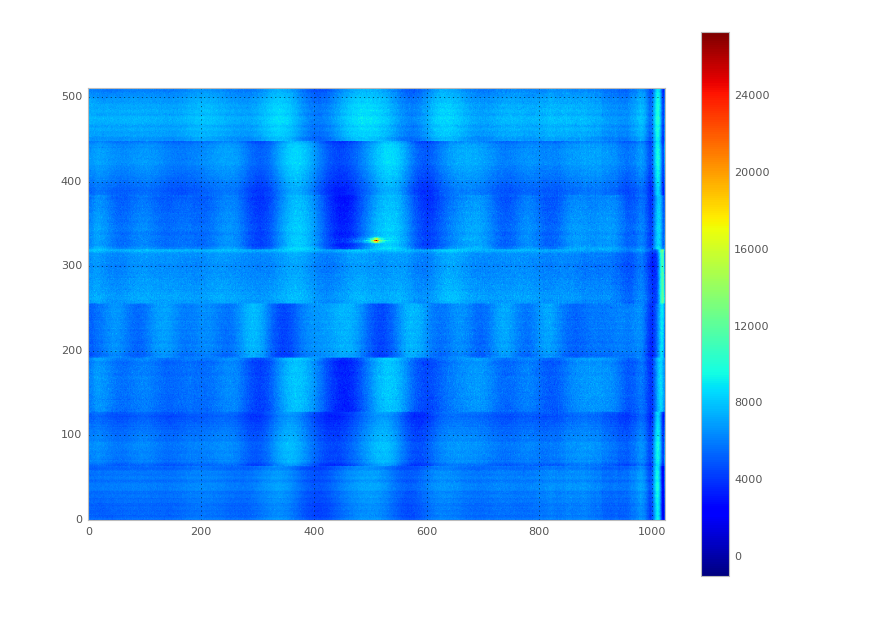


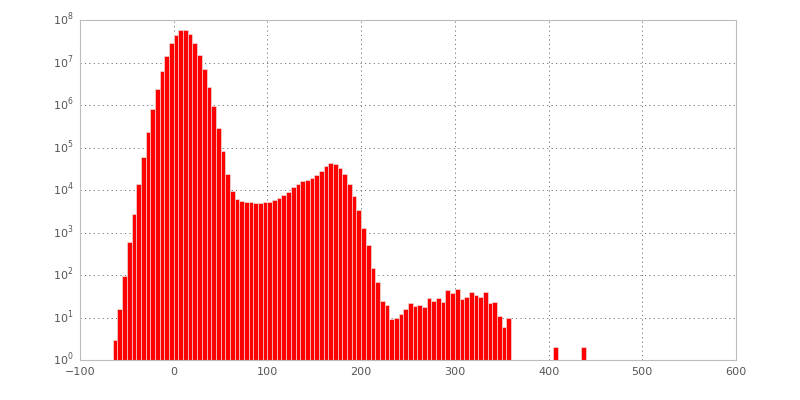


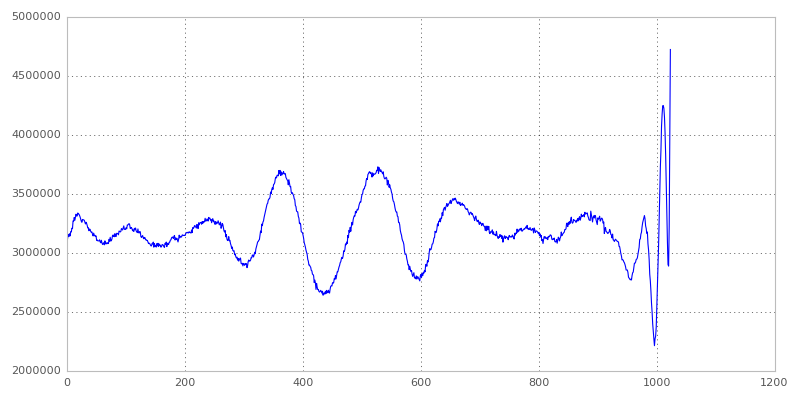

In [34]:
res_nocorr = get_I0_spectra(DIR + "206200.h5")
tmp_res = res_nocorr
print tmp_res["elapsed_time"]

plt.figure()
plt.imshow(tmp_res["sum_image_noroi"].T, aspect=1.5)  # 'aspect' is the x/y ratio
plt.colorbar()
plt.figure(figsize=(10, 5))
plt.bar(tmp_res["adu_bins"][:-90], tmp_res["adu_histo"][:-89], log=True, width=(tmp_res["adu_bins"][1] - tmp_res["adu_bins"][0]))
plt.figure(figsize=(10, 5))
plt.plot(tmp_res["spectra"].sum(axis=0))
plt.tight_layout()
plt.show()


The $K_\beta$ peak can be seen, it lies within a detector strip (good), but the spectra is still dominated by noise. Also, there is a _double peak_ structure in the second ADU peak. Let's define a proper ROI:

int64
53.1348040104



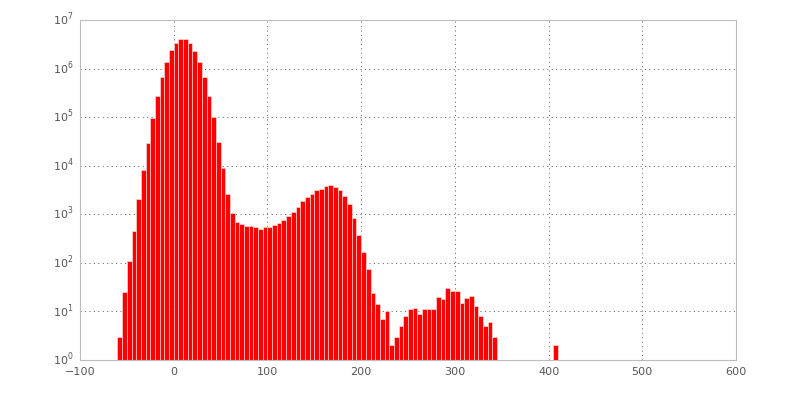


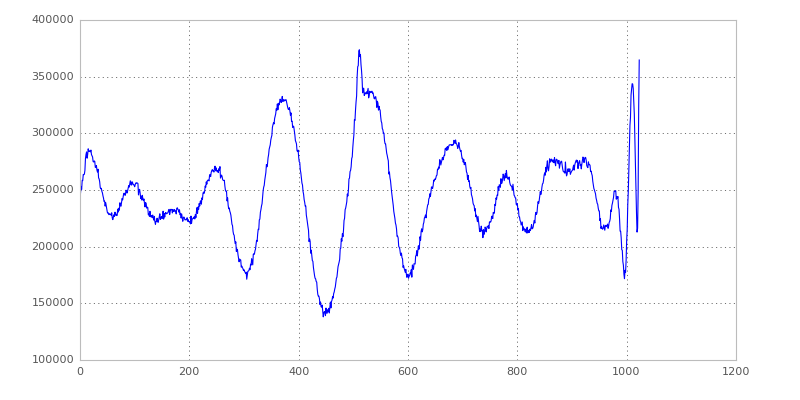

In [35]:
roi = [[0, 1024], [320, 360]]
res_roi_nocorr = get_I0_spectra(DIR + "206200.h5", roi=roi)
tmp_res = res_roi_nocorr

print tmp_res["elapsed_time"]
plt.figure(figsize=(10, 5))
plt.bar(tmp_res["adu_bins"][:-90], tmp_res["adu_histo"][:-89], log=True, width=(tmp_res["adu_bins"][1] - tmp_res["adu_bins"][0]))
plt.figure(figsize=(10, 5))
plt.plot(tmp_res["spectra"].sum(axis=0))
plt.show()

So, the ROI seems good enough, and signal lies in one detector strip. Also, the double peak structure is reduced. 

$K_\beta$ starts to show, but still too much noise! Let's add a dark image correction computes on each dataset, using `ADU<70` (just because I have no clue where the dark images are...)

int64
101.950932026



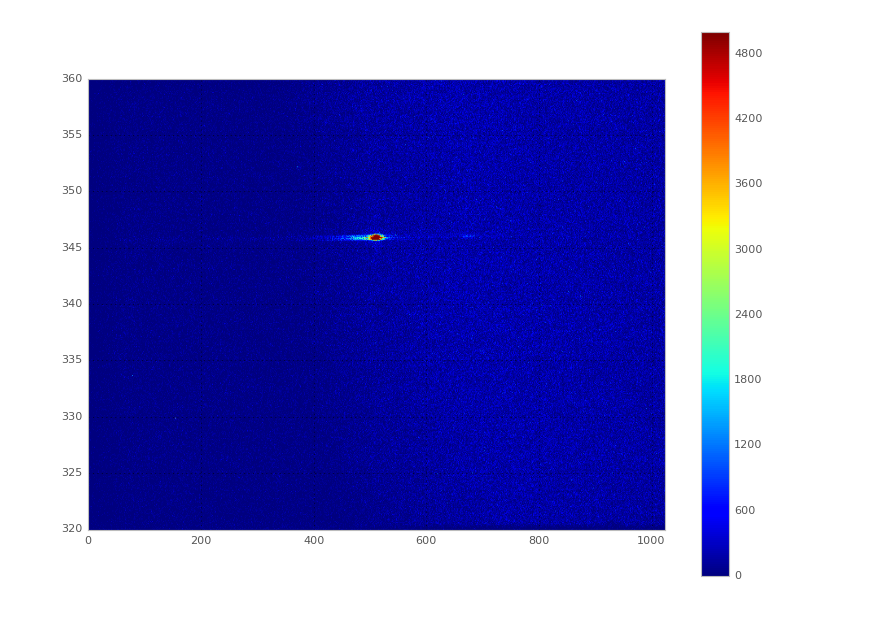


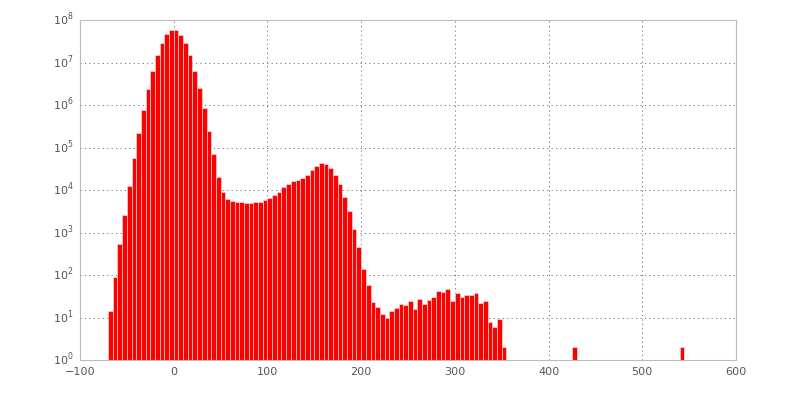


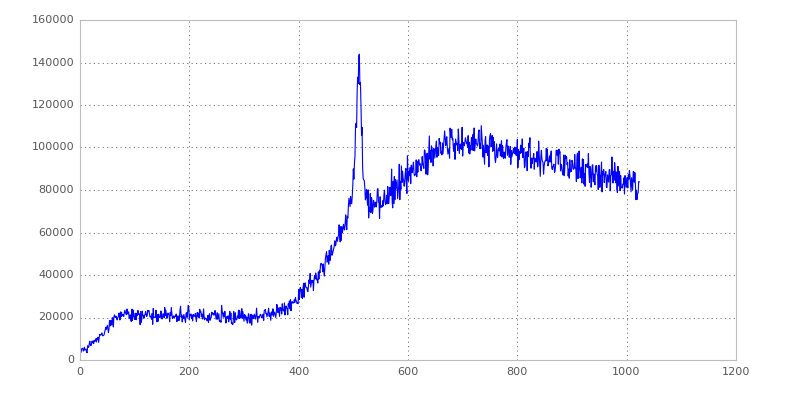

In [36]:
res_corr = get_I0_spectra(DIR + "206200.h5", corr=True, corr_thr=70.)
tmp_res = res_corr
print tmp_res["elapsed_time"]

plt.figure()
plt.imshow(tmp_res["sum_image_noroi"].T, aspect=20, extent=(roi[0][0], roi[0][1], roi[1][0], roi[1][1]), vmax=5000)  # 'aspect' is the x/y ratio
plt.colorbar()
plt.figure(figsize=(10, 5))
plt.bar(tmp_res["adu_bins"][:-90], tmp_res["adu_histo"][:-89], log=True, width=(tmp_res["adu_bins"][1] - tmp_res["adu_bins"][0]))
plt.figure(figsize=(10, 5))
plt.plot(tmp_res["spectra"].sum(axis=0))
plt.show()

Even without ROI is already much better! The double peak remains, probably due to the residual illumination gradient that can be seen in the corrected image sum. Adding the usual ROI selection:

int64
73.4526820183



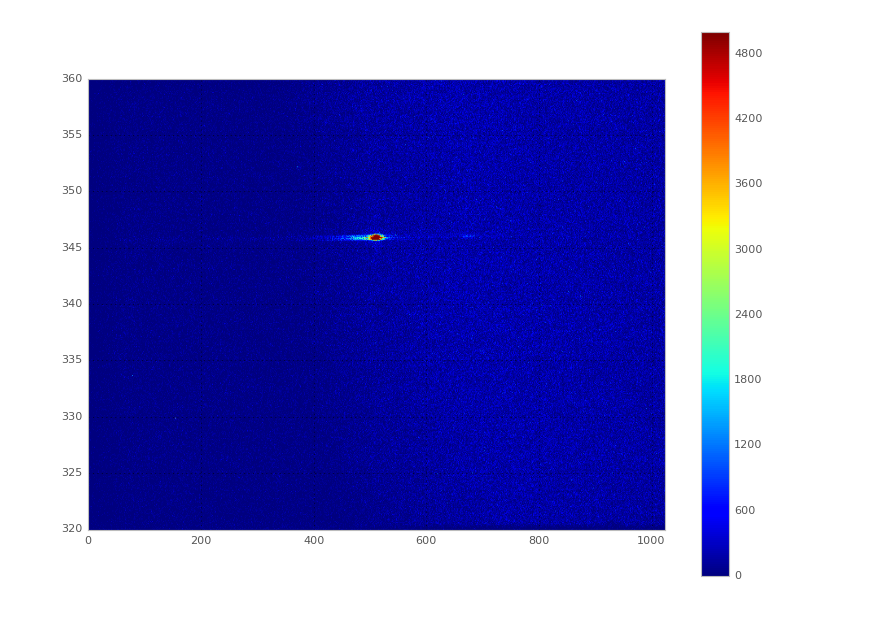


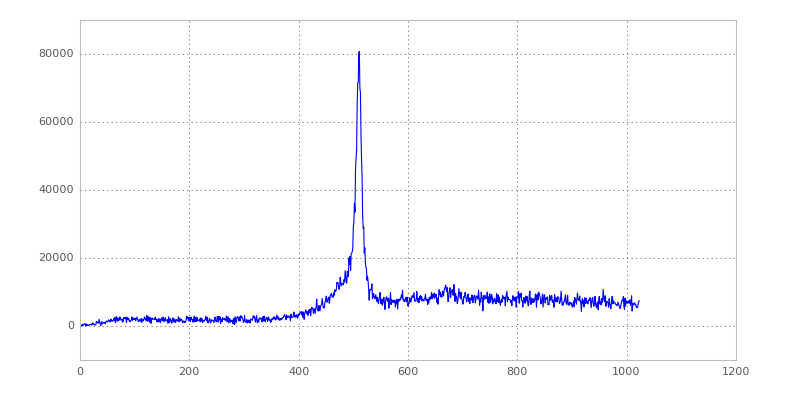

In [37]:
roi = [[0, 1024], [320, 360]]
res_roi_corr = get_I0_spectra(DIR + "206200.h5", corr=True, corr_thr=70., roi=roi)
tmp_res = res_roi_corr
print tmp_res["elapsed_time"]

plt.figure()
plt.imshow(tmp_res["sum_image_noroi"].T, aspect=20, extent=(roi[0][0], roi[0][1], roi[1][0], roi[1][1]), vmax=5000)  # 'aspect' is the x/y ratio
plt.colorbar()
plt.figure(figsize=(10, 5))
plt.plot(tmp_res["spectra"].sum(axis=0))
plt.show()

So, getting the dark images from each dataset using a ADU<70 threshold seems to work, but there is still a illumination gradient from `x~500`... this is probably due to the bad shielding, and should be constant in X. So, lets' see if we can remove it:


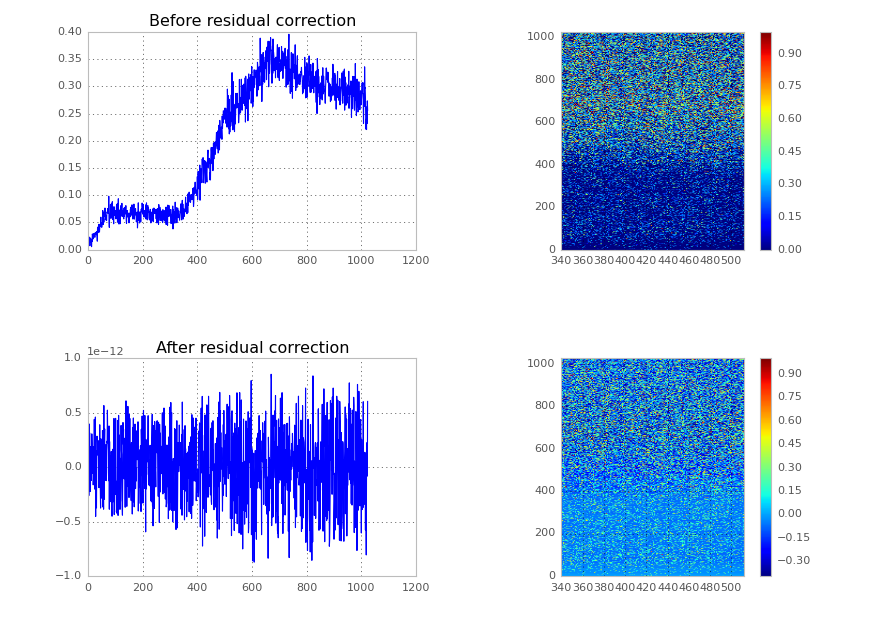

In [38]:
fname = DIR + "206200.h5"
f = h5py.File(fname)
run = f.keys()[-1]
prefix = run + "/daq_info/"
dset_name = run + "/detector_2d_9"
# getting the list of tags with images

tags_list = f[dset_name].keys()[1:]
tags = f[run + "/event_info/tag_number_list"].value
correction = ut.analysis.per_pixel_correction_sacla(f[dset_name + "/"], tags, thr=70)
images = None
for i, t in enumerate(tags_list):
        image = (f[dset_name + "/" + t + "/detector_data"] - correction)[:, 340:]
        if images is None:
            images = np.ndarray([len(tags_list), image.shape[0], image.shape[1]])
        images[i] = image

spectrum_mean = images.mean(axis=0).mean(axis=1)
plt.figure()
plt.subplot(2, 2, 1)
plt.title("Before residual correction")
plt.plot(spectrum_mean)
plt.subplot(2, 2, 2)
plt.imshow(images.mean(axis=0), extent=(340, 512, 0, 1024), aspect=0.2, vmax=1)
plt.colorbar()
plt.subplot(2, 2, 3)
plt.title("After residual correction")
corr_imgs = images[:, :, ] - spectrum_mean[np.newaxis, :, np.newaxis]
plt.plot(corr_imgs.mean(axis=0).sum(axis=1))
plt.subplot(2, 2, 4)
plt.imshow(corr_imgs.mean(axis=0), extent=(340, 512, 0, 1024), aspect=0.2, vmax=1)
plt.colorbar()
plt.show()


But there are still a lot of very bright peaks... Another way is also possible: given that we are interested in the spectra of the sum of all the images in a run, we can just take the histogram of the "control" strip for all the images, normalize it for the ratio of areas

$$
N = \frac{A_{signal} }{A_{control}}
$$

and it should work! Please notice that it is still an approximation, as the residual illumination has a weak dependency on X.


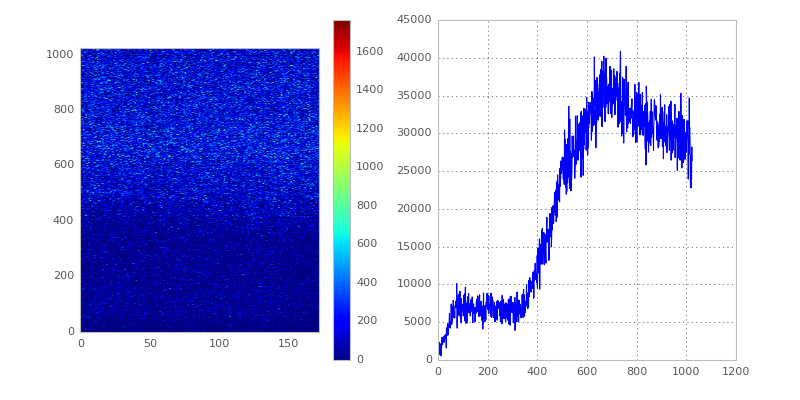


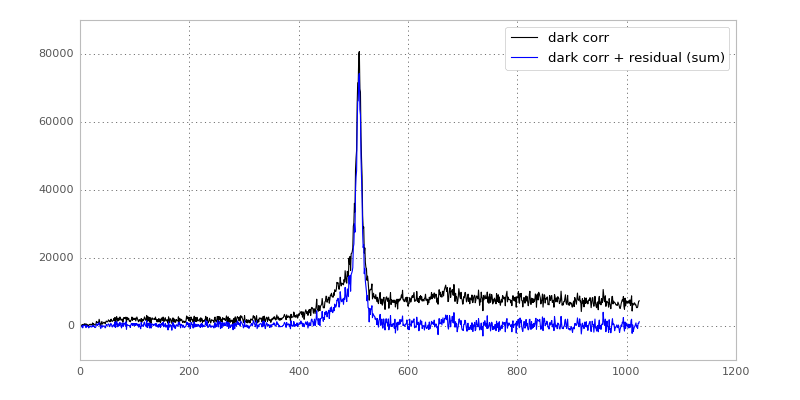

In [39]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(images.sum(axis=0), aspect=0.2)
plt.colorbar()
plt.subplot(122)
plt.plot(images.sum(axis=0).sum(axis=1))

roi = [[0, 1024], [320, 360]]
control_roi = [[0, 1024], [340, 512]]
N = float(roi[1][1] - roi[1][0]) / (control_roi[1][1] - control_roi[1][0])
plt.figure(figsize=(10, 5))
plt.plot(res_roi_corr["spectra"].sum(axis=0), color='k', label="dark corr")
plt.plot(res_roi_corr["spectra"].sum(axis=0) - N * images.sum(axis=0).sum(axis=1), label="dark corr + residual (sum)")
plt.legend(loc='best')
plt.show()

So far so good! Let's check without ROI:


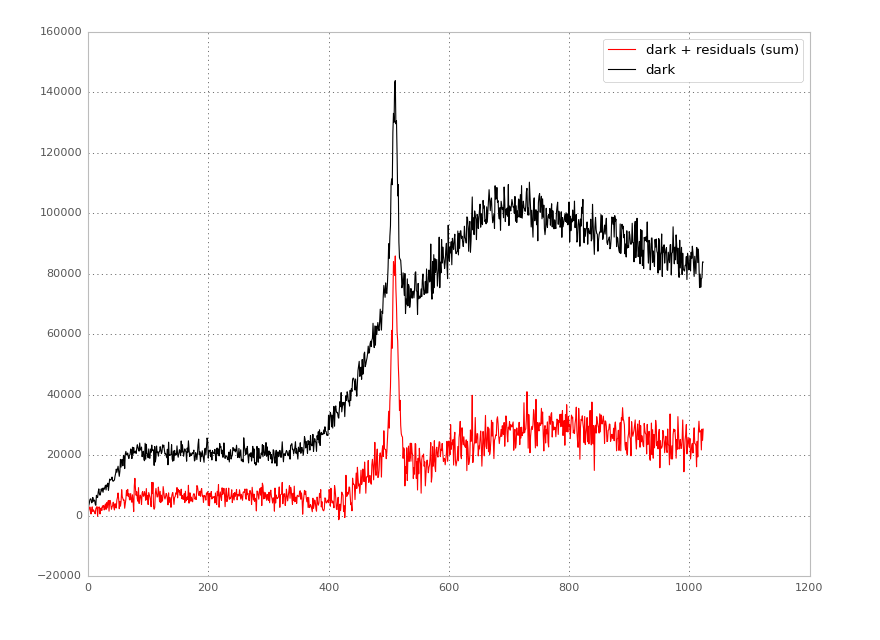

In [40]:
roi = [[0, 1024], [0, 360]]
control_roi = [[0, 1024], [340, 512]]
N = float(roi[1][1] - roi[1][0]) / (control_roi[1][1] - control_roi[1][0])
res_sum_corr = images.sum(axis=0).sum(axis=1)

plt.figure()
plt.plot(res_corr["spectra"].sum(axis=0) - N * res_sum_corr, label="dark + residuals (sum)", color='r')
plt.plot(res_corr["spectra"].sum(axis=0), label="dark", color='k')
plt.legend(loc="best")
plt.show()


Even if applied to the whole image, the `residual correction (sum)` seems to perform better. Neverhteless, there is some diffuse illumination around $Y~560$  and $Y~830$ that has no explanation... Looking at the image, it seems that spans over all $x$s, so ti can be a residual effect of the problematic shielding

int64



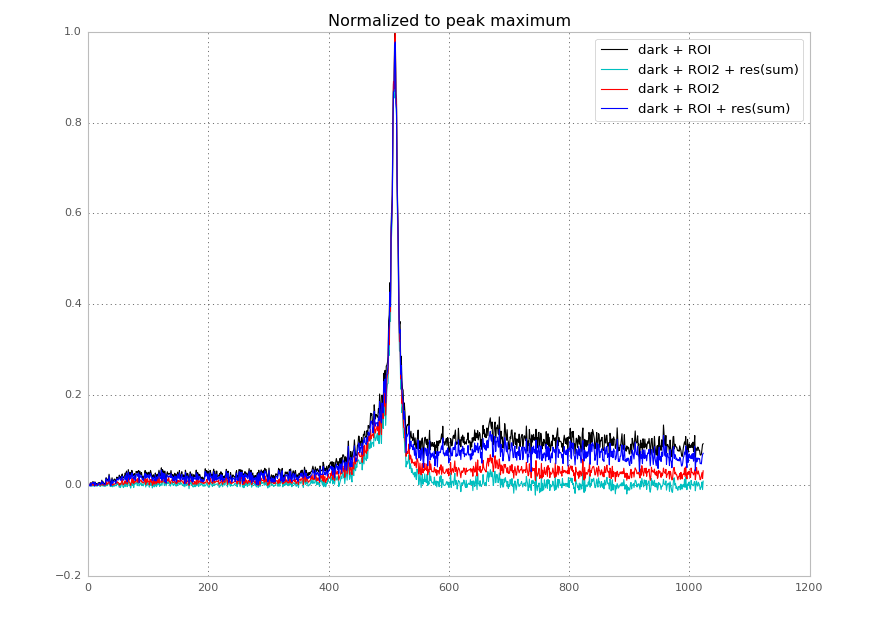

In [41]:
roi2 = [[0, 1024], [325, 336]]
res_roi2_corr = get_I0_spectra(DIR + "206200.h5", corr=True, corr_thr=70., roi=roi2, )

control_roi = [[0, 1024], [340, 512]]
N = float(roi[1][1] - roi[1][0]) / (control_roi[1][1] - control_roi[1][0])
N2 = float(roi2[1][1] - roi2[1][0]) / (control_roi[1][1] - control_roi[1][0])
res_sum_corr = images.sum(axis=0).sum(axis=1)

plt.figure()
plt.plot(res_roi_corr["spectra"].sum(axis=0) / res_roi_corr["spectra"].sum(axis=0).max(), label="dark + ROI", color='k')
plt.plot((res_roi2_corr["spectra"].sum(axis=0) - N2 * res_sum_corr) / res_roi2_corr["spectra"].sum(axis=0).max(), label="dark + ROI2 + res(sum)", color='c')
plt.plot((res_roi2_corr["spectra"].sum(axis=0)) / res_roi2_corr["spectra"].sum(axis=0).max(), label="dark + ROI2", color='r')
plt.plot((res_roi_corr["spectra"].sum(axis=0) - N2 * res_sum_corr) / res_roi_corr["spectra"].sum(axis=0).max(), label="dark + ROI + res(sum)", )

plt.title("Normalized to peak maximum")
plt.legend(loc="best")
plt.show()

It seems we can get rid of that strange diffuse peak around `Y=569` just with a reduction of the ROI.

In the end, the `residual correction (sum)` seems to hold the best results, but at the moment are still limited... given that this correction can be easily applied even later (we are saving the sum of all the images nevertheless), better not to implement anything yet in data reduction.

We can apply this function to all files in a loop: straightforward, but we do not profit from the many cores of the machine we are running on!

In [15]:
# how fast is a normal loop?
results_loop = []
files = [ DIR + x  for x in os.listdir(DIR) if os.path.isfile(DIR + x)]

t0 = time()
for f in files[0:8]:
    res = get_I0_spectra(f, corr=True, corr_thr=70., roi=roi2)
    if res["elapsed_time"] == -1:
        continue
    results_loop.append(res)
print "Total time:", time() - t0
# For the first 8 files, is: Total time: Total time: ~86 s (actually it is only 4 files, the other 4 have basically no data)

int64
int64
int64
int64
int64
int64
int64
int64
Total time: 91.0104379654


We can use the IPython parallel engine to run the `get_I0_spectra` function on many files in parallel. Before this, start some workers in the Ipython Home page (http://127.0.0.1:8888 or else, see the URL in your browser) -> Clusters tab -> Select #engines=8 and start.

The `load_balanced_view` object acts as a simple scheduler: we can map a function to a sequence (in this case, a list of files), and `lview` takes care of sending the jobs at the right time. For further info, see: 
   
   * http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/21_IPythonParallel
   * http://ipython.org/ipython-doc/2/parallel/parallel_task.html
   
The easiest thing is to just send the functions we have already defined on the IPython parallel cluster. We need to pay attention that in this case we need to **pass the parameters in the correct order**!

In [43]:
# Map the function to the list of files! Running only on the first 8 files
files = [ DIR + x  for x in os.listdir(DIR) if os.path.isfile(DIR + x)][0:8]
t0 = time()

# the parameters
roi = [[0, 1024], [325, 336]]
adu_thr = 0.
corr = True
corr_thr = 70.

# running in parallel
pres = lview.map(get_I0_spectra, files,  len(files)*[roi], len(files)*[adu_thr], len(files)*[corr], 
                 len(files)*[corr_thr])
print "Total time:", time() - t0
# For the first 8 files, is: Total time: 68.219201088

Total time: 40.2149329185



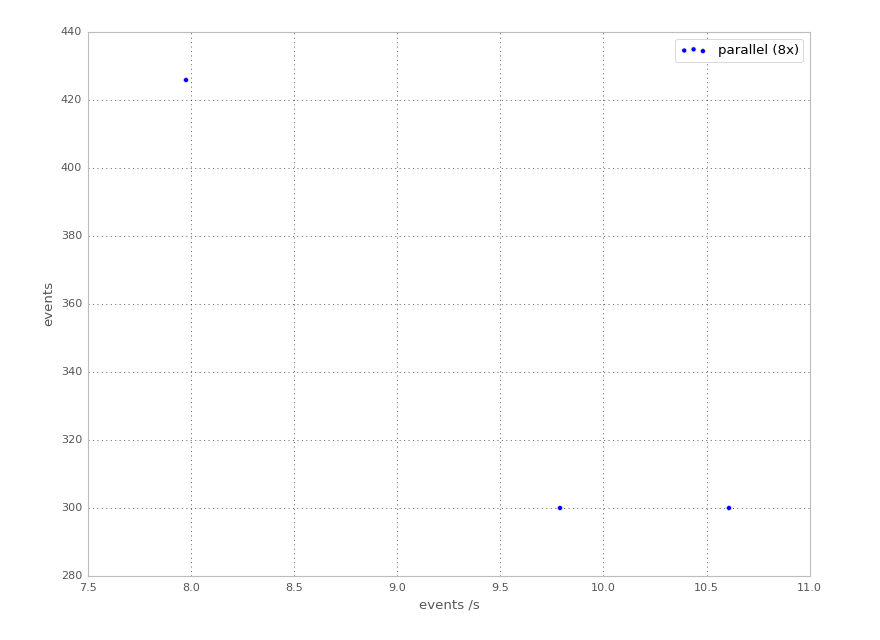

In [28]:
plt.figure()
evts_per_sec = [ x["events_s"] for x in pres if x["events_s"] != -1]
evts = [ len(x["sum_of_img_counts"]) for x in pres if x["events_s"] != -1]
plt.scatter(evts_per_sec, evts, label="parallel (8x)")
#levts_per_sec = [ x["events_s"] for x in results_loop if x["events_s"] != -1]
#levts = [ len(x["sum_of_img_counts"]) for x in results_loop if x["events_s"] != -1]
#plt.scatter(levts_per_sec, levts, color="k", marker="v", label="serial")
plt.xlabel("events /s")
plt.ylabel("events")
plt.legend(loc="best")
plt.show()

So, it seems that there are no performace bottlenecks in this case for doing a trivial parallelization (there could have been disk contention for example). Parallel sounds good!

Let's finally produce some plots! Let's do a scatter plot of `I0` vs the sum of all ADUs per image, plus some histos:


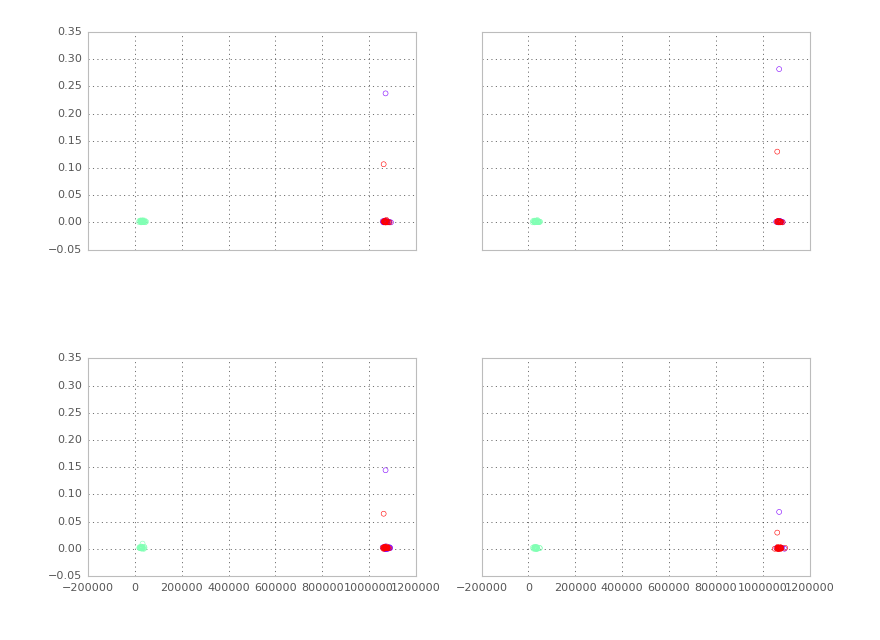


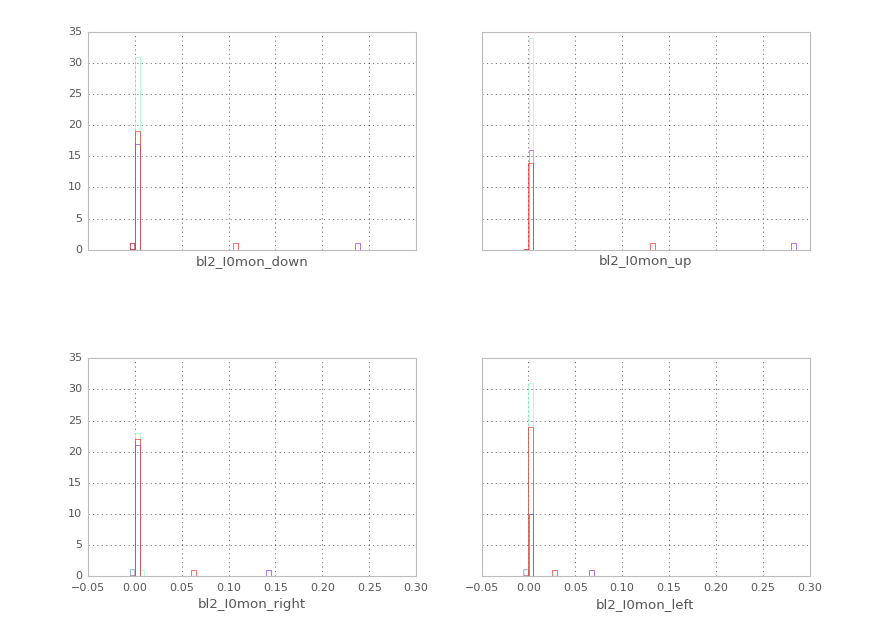

In [45]:
# Filter out bad results
pres2 = [ x for x in pres if x["elapsed_time"] != -1]

# create the two figs
figs, axes = plt.subplots(2, 2, sharex=True, sharey=True)
figs_h, axes_h = plt.subplots(2, 2, sharex=True, sharey=True)

# create a color map iterator
colors = iter(cm.rainbow(np.linspace(0, 1, len(pres2))))
# quantities to be plotted
quants = ["bl2_I0mon_down", "bl2_I0mon_up", "bl2_I0mon_right", "bl2_I0mon_left"]
for j, res in enumerate(pres2):
    color = next(colors)
    for i, ax in enumerate(axes.reshape(-1)):
        ax.scatter(res["sum_of_img_counts"], res[quants[i]], color=color, marker="o", facecolors='none', 
                   edgecolors=color, label=res["run"])
        q = res[quants[i]]
        q2 = q[~np.isnan(q)]
        if len(q2) == 0:
            continue
        axes_h.reshape(-1)[i].set_xlabel(quants[i])
        step = 0.005
        axes_h.reshape(-1)[i].hist(q2, np.arange(q2.min() - step, q2.max() + step, step), fill=False, edgecolor=color )

plt.legend(loc="best")
plt.show()

Need the total I0?


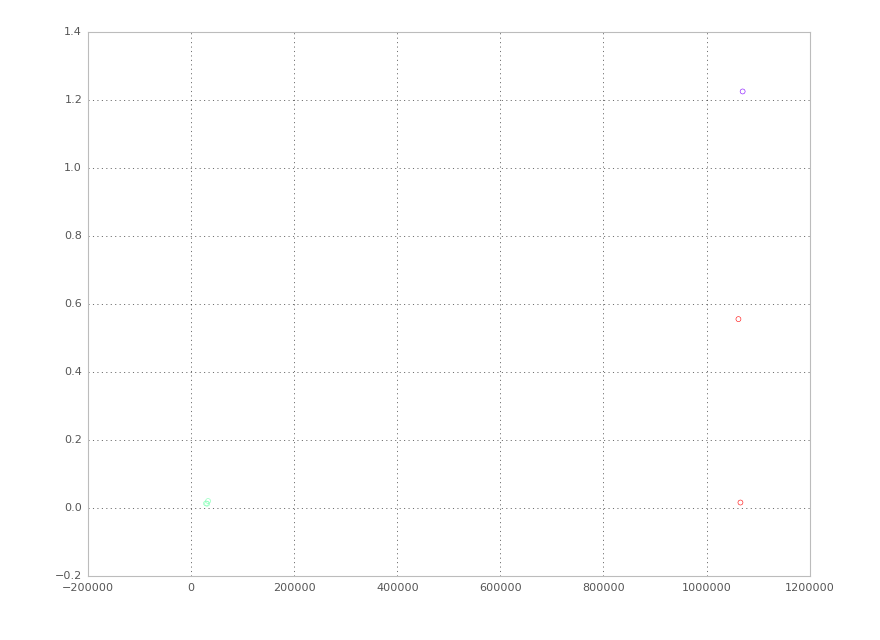


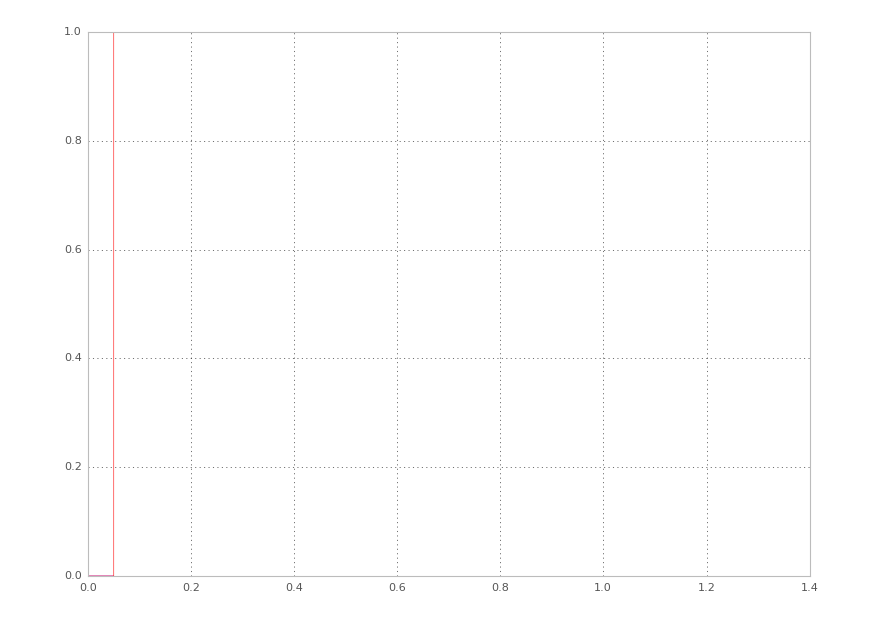

In [47]:
figs3, axes3 = plt.subplots(1, sharex=True, sharey=True)
figs_h3, axes_h3 = plt.subplots(1, sharex=True, sharey=True)

colors = iter(cm.rainbow(np.linspace(0, 1, len(pres2))))
quants = ["bl2_I0mon_down", "bl2_I0mon_up", "bl2_I0mon_right", "bl2_I0mon_left"]
        
for j, res in enumerate(pres2):
    color = next(colors)
    I0 = None
    for q in quants:
        if I0 is None:
            I0 = res[q]
        else:
            I0 += res[q]
        #print j, q, I0[0]
    
    axes3.scatter(res["sum_of_img_counts"], I0, marker="o", facecolors='none', 
                   edgecolors=color, label=res["run"])
    plt.legend(loc="best")
    I0 = I0[~np.isnan(I0)]
    if len(I0) == 0:
        continue
    axes_h3.hist(I0, np.arange(0, I0.max(), 0.05), fill=False, edgecolor=color )
plt.show()

From the spectra, we can see that:

* run 206054 is a *dark run*
* runs 206052 and 206053 have something strange (MPCCD on high gain?)

In [ ]:
figs_h4, axes_h4 = plt.subplots(1, sharex=True, sharey=True)

colors = iter(cm.rainbow(np.linspace(0, 1, len(pres2))))
quants = ["bl2_I0mon_down", "bl2_I0mon_up", "bl2_I0mon_right", "bl2_I0mon_left"]
        
for j, res in enumerate(pres2):
    color = next(colors)
    axes_h4.plot(res["spectra"].sum(axis=0), color=color, label=res["run"])

plt.legend(loc='best')
plt.show()

Time to run on all the files!

In [ ]:
files = [ DIR + x  for x in os.listdir(DIR) if os.path.isfile(DIR + x)]
# the parameters
roi = [[0, 1024], [325, 336]]
adu_thr = 0.
corr = True
corr_thr = 70.

t0 = time()
# running in parallel

# Very dangerous option, as it prints out also the results buffer (which can be pretty big, and horribly kill your browser)
# Use it only on one file, to debug sth otherwise impossible to debug...
#rc.debug = True
pres_all = lview.map(get_I0_spectra, files,  len(files)*[roi], len(files)*[adu_thr], len(files)*[corr], len(files)*[corr_thr], )

print "Total Time %.1f" % (time() - t0)

In [ ]:
figs_h5, axes_h5 = plt.subplots(1, sharex=True, sharey=True)
pres3 = [ x for x in pres_all if x["elapsed_time"] != -1]

colors = iter(cm.rainbow(np.linspace(0, 1, len(pres3))))
quants = ["bl2_I0mon_down", "bl2_I0mon_up", "bl2_I0mon_right", "bl2_I0mon_left"]
        
for j, res in enumerate(pres3):
    color = next(colors)
    axes_h5.plot(res["spectra"].sum(axis=0), color=color, label=res["run"])

plt.legend(loc='best')
plt.show()

# Saving your data to HDF5 for later analysis

Once we are happy with the preprocessing steps, we can just dump all the processed data to an HDF5, so that we can efficiently analyse it later. One possible structure is `/run/quant`, e.g. `/run_XXXX/is_laser`

In [ ]:
output_fname = "/swissfel/photonics/sala/reduced_sacla_all3.h5"
# a simple string identifying the set of cuts applied
cut_set_label = "selfdark70_roi1"
comment = "Self dark correction with thr<70, roi = [[0, 1024], [325, 336]]"

pres3 = [ x for x in pres_all if x["source_filename"] != ""]
output_file = h5py.File(output_fname, "w")
runs = [x["run"] for x in pres3]

for result in pres3:
    print result["source_filename"]
    f_source = h5py.File(result["source_filename"])
    grp = output_file.require_group(cut_set_label + "/run_" + str(result["run"]))
    event_info_grp = f_source["/run_" + str(result["run"]) + "/event_info"]
    output_file.copy(event_info_grp, cut_set_label + "/run_" + str(result["run"]) + "/event_info")
    daq_info_grp = f_source["/run_" + str(result["run"]) + "/daq_info"]
    output_file.copy(daq_info_grp, cut_set_label + "/run_" + str(result["run"]) + "/daq_info")
    grp.attrs["comments"] = np.string_(comment)
    for k, v in result.iteritems():
        if k == "source_filename":
            grp.attrs["source_filename"] = v
            continue
        dset_name = k
        try:
            dset_type = v.dtype
            dset_shape = v.shape
            grp.require_dataset(dset_name, shape=dset_shape, dtype=dset_type, data=v[:])
        except:
            dset_type = type(v)
            dset_shape = 1
            grp.require_dataset(dset_name, dtype=dset_type, shape=(dset_shape, ), data=v)
            
output_file.close()



# "Advanced stuff"

## Creating an analysis object

One thing we can do is to construct an Analysis object: this will simplify sending out the analysis function to all the nodes:

In [ ]:
%%px --local

from time import time
import h5py
import numpy as np
import sys, os
sys.path.append( os.environ["PWD"]+"/../" )
import utilities as ut
# with the above line, the class is defined both locally and on the workers
class Analysis(object):
    reload(ut)
    reload(ut.analysis)

    def __init__(self):
        self.roi = []
        self.adu_thr = 0.
        self.corr = False
        self.corr_thr = 0.
        self.residual_corr = False
        #self.fname = fname
    
    def __call__(self, fname):
        return self.get_I0_spectra(fname, roi=self.roi, adu_thr=self.adu_thr, corr=self.corr, 
                            corr_thr=self.corr_thr, residual_corr=self.residual_corr)
    
    @staticmethod
    def loop_on_images(f, tags_list, dset_name, corr=None):
        sum_of_counts = []
        histo = None
        bins = None
        # counting total counts, one image per time (sigh...)
        images = None

        for i, t in enumerate(tags_list):
            image = f[dset_name + "/" + str(t) + "/detector_data"][:]
            if corr is not None:
                image -= corr

            sum_of_counts.append(image.sum())
            t_histo, bins = np.histogram(image, bins=range(-100, 1000, 5))
            if histo is None:
                histo = t_histo
            else:
                histo += t_histo
            if corr is None:
                continue

            if images is None:
                images = np.ndarray([len(tags_list), image[:, 340: 360].shape[0], image[:, 340:360 ].shape[1]])
            images[i] = image[:, 340:360]
        if images is None:
            lumi_corr = None
        else:
            lumi_corr = images.mean(axis=0).mean(axis=1)
        return sum_of_counts, histo, bins, lumi_corr

    
    def get_I0_spectra(self, fname, roi=[], adu_thr=0., corr=False, corr_thr=0., residual_corr=False):
        
        sys.path.append( os.environ["PWD"]+"/../" )

        results = {}
        t0 = time()
        try:
            f = h5py.File(fname)
            run = f.keys()[-1]
            prefix = run + "/daq_info/"
            tags = f[run + "/event_info/tag_number_list"].value
        except:
            return {"sum_of_img_counts": [], "elapsed_time": -1, "events_s": -1}

        dset_name = ""
        if "detector_2d_9" in f[run].keys():
            dset_name = run + "/detector_2d_9"
        elif "detector_2d_1" in f[run].keys():
            dset_name = run + "/detector_2d_1"
        else:
            return {"sum_of_img_counts": [], "elapsed_time": -1, "events_s": -1}

        # getting the list of tags with images
        tags_list = f[dset_name].keys()[1:]
        # from text to ints
        image_tags_list = [ int(x.replace("tag_", "")) for x in tags_list]
        # getting the spectra
        correction = None
        if corr:
            correction = ut.analysis.per_pixel_correction_sacla(f[dset_name + "/"], tags, thr=corr_thr)
        sum_of_counts, histo, bins, lumi_corr = self.loop_on_images(f, tags_list, dset_name, corr=correction)
        if corr and residual_corr:
            correction[:, ] += lumi_corr[:, np.newaxis]

        sum_image, spectrum = ut.analysis.get_spectrum_sacla(f[dset_name + "/"], tags, thr=adu_thr, roi=roi, corr=correction)  # masks=masks)
        tags_mask = [np.in1d(tags, image_tags_list)]

        for k, v in f[prefix].iteritems():
            results[k] = v[:][tags_mask]

        te = time() - t0
        results["run"] = int(run.replace("run_", ""))
        results["tags"] = image_tags_list
        results["sum_of_img_counts"] = sum_of_counts
        results["elapsed_time"] = te
        results["events_s"] = len(image_tags_list) / te
        results["spectrum"] = spectrum
        results["sum_image"] = sum_image
        results["adu_histo"] = histo
        results["adu_bins"] = bins
        results["is_laser"] = f[run + "/event_info/bl_3/lh_1/laser_pulse_selector_status"][:]
        results["correction"] = correction
        return results

If you do not want do define an `Class`, then you can keep the code used locally, but you need to maintain the order of the arguments: if the arguments are called in the order
```
get_I0_spectra(fname, roi=[], adu_thr=0., corr=False, corr_thr=0., residual_corr=False)
```

now you have to do:
```
pres = lview.map(my_analysis, files, len(files)*[roi_value], len(files)*[adu_thr_value], len(files)*[corr_value], <...>)
```

where e.g. `roi_value` is `[[0, 1024], [0,300]]`. The pain here can be that you have to pass arrays of parameters, even if the parameters are constant but one (the filename in this case). Your call.


Now, we can run in parallel, setting the analysis parameters as properties of the analysis object:

In [ ]:
# Map the function to the list of files!
files = [ DIR + x  for x in os.listdir(DIR) if os.path.isfile(DIR + x)]
t0 = time()
# the parameters
my_analysis = Analysis()
my_analysis.roi = [[0, 1024], [325, 336]]
my_analysis.corr = True
my_analysis.corr_thr = 70.
my_analysis.residual_corr = True

# running in parallel
pres_adv = lview.map(my_analysis, files[0:8], )
print "Total time:", time() - t0
# For the first 8 files, is: Total time: 15.2590560913